In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib.animation import FFMpegWriter

import pandas as pd

In [2]:
%matplotlib notebook

### Read data with pandas and cut a fraction to visualize

In [3]:
df = pd.read_csv("Data/SO_Raster_Compte2d_GabaA1.000_GabaB1.000_Sync0.000_seed1564989.dat", sep = "\t", header = None)

df[0] = df[0].round(decimals = 2)


data_start = 10 # in s
data_end = 20 # in s

# data_start = 2 # in s
# data_end = 4 # in s

dt = 0.01 # in s
delay = 10 # in steps
delays = np.arange(0,1,0.1) # 10 delays
delays = delays[::-1]
lenvec = int( (data_end - data_start) / dt )


df = df.drop(df[df[0] < data_start].index)
df = df.drop(df[df[0] > data_end].index)

df.index = range(len(df[0])) # recreate indexes from 0 to ...


number_of_neurons = int(df[1].max())



### I will implement the following idea:
Create a matrix LxL where L=50 (the data comes from a 50x50 network)\
For each position create a vector of time with a fixed len and identical for all neurons.\
Fullfill the vector of time with 0 (no-spike) and 1 (spike). The index of the vector will carry the time ( index*dt = current time)\
If neuron spike, decay its value from 1 to 0 in n-delay steps. This will be helpful for visualization later.\
Ex: [0][0] = [0,0,0,0,1,0,0,0,0,0,0,0,0,1,...] \
Ex. with decay: [0][0] = [0,0,0,1,0.8,0.6,0.4,0.2,0,0,0,0,1,....]

In [4]:
# Create matrix and store elements

Matrix_spikes = np.zeros((50,50,lenvec+1)) # create matrix 50 by 50 with time vector

aux = 0
for i in range(number_of_neurons):
    if not (i%50) and (i!=0):
        aux+=1        
        spike_indexes = ((df[0][np.where(df[1]==i)[0]].to_numpy())*(1./dt) - (data_start/dt)).astype(int)
        for k in spike_indexes:
            Matrix_spikes[aux][i-(50*aux)][k] = 1
            if(k<(lenvec-delay)):
                Matrix_spikes[aux][i-(50*aux)][k:(k+delay)] = delays
    else:
        spike_indexes = ((df[0][np.where(df[1]==i)[0]].to_numpy())*(1./dt) - (data_start/dt)).astype(int)
        for k in spike_indexes:
            Matrix_spikes[aux][i-(50*aux)][k] = 1
            if(k<(lenvec-delay)):
                Matrix_spikes[aux][i-(50*aux)][k:(k+delay)] = delays

<IPython.core.display.Javascript object>


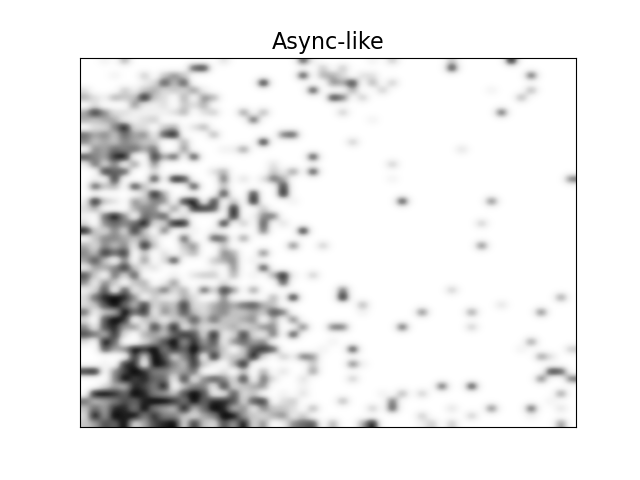

In [6]:
# FIGURE ANIMATED

# frames = equivalente to range(frames)
# interval = delay between frames

fig, ax = plt.subplots()
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.set_title("Async-like", fontsize=16)


def update(i):
    ax.imshow(Matrix_spikes[:,:,i+25], interpolation = 'gaussian', aspect = 'auto', cmap = 'Greys')

anim = FuncAnimation(fig, update, frames = 150, interval = 0.01)
plt.show()

In [7]:
# Save figure
writevideo = FFMpegWriter(fps=10)
anim.save('Async_PCI.mp4', writer = writevideo)